![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 2**

La detección de objetos en imágenes es una aplicación clave de la inteligencia artificial y el aprendizaje profundo. En este taller, exploraremos cómo construir un modelo de detección de objetos utilizando redes neuronales para identificar y ubicar rostros humanos en imágenes. Por ejemplo, en un entorno de seguridad y vigilancia, un sistema de detección de rostros basado en redes neuronales podría utilizarse para identificar personas en tiempo real a partir de cámaras de seguridad. Esto puede ser especialmente útil en áreas como aeropuertos, estaciones de tren, edificios gubernamentales o empresas que requieren un alto nivel de seguridad.

El objetivo principal de este taller es construir una Red Neuronal para la detección de rostros humanos utilizando modelos pre-entrenados.

1.   Construir una RN de detección de rostros usando un modelo pre-entrenado. (Si bien en el laboratorio se usó Yolov5 pueden usar otra versión y otra red). Recuerden ser descriptivos en el Preprocesamiento de Datos, Utilización de Modelos Pre-entrenados, Evaluación de Rendimiento y búsqueda de hiperparámetros.

3.  Proporcionar algunos ejemplos de detección de objetos con la red entrenada y lo comparen con la imagen con los datos anotados. Traten de usar imágenes con 1 rostro asi como imágenes con varios rostros.

4.  Investigar la métrica mAP y cómo la interpreta para la red entrenada.

Recursos:
•	Conjunto de datos "[Human Faces Object Detection](https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection)" de Kaggle.


# Librerías necesarias

En primera instancia, se configura el entorno de trabajo para tareas relacionadas con el aprendizaje automático y el procesamiento de imágenes utilizando TensorFlow, scikit-learn y otras librerías útiles para llevar a cabo la manipulación de los datos de entrada y la construcción de los modelos requeridos.

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils import plot_model
import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch

import os
import shutil
from xml.etree import ElementTree as ET
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import glob

print('Tensorflow version:', tf.__version__)

Using TensorFlow backend
Tensorflow version: 2.13.0


# Lectura y entendimiento de los datos

El código a continuación ejecuta una serie de acciones enfocadas en la descarga y preparación de una colección de datos de Kaggle, facilitando la obtención de las imágenes que se utilizarán en el entrenamiento de los modelos. En primer lugar, se configura la autenticación copiando el archivo de credenciales 'kaggle.json' en el directorio adecuado, estableciendo permisos de lectura y escritura. Posteriormente, se verifica la conexión a Kaggle y se procede a descargar el conjunto de datos de interés ([Human Faces Dataset](https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection)). Luego, se descomprime el archivo y se imprime el número de elementos que se hallan en los dos directorios existentes.

In [ ]:
!ls -lha kaggle.json

# Instalar el paquete Kaggle
!pip install -q kaggle

# Crear el directorio .kaggle
!mkdir -p ~/.kaggle

# Mover la llave al directorio creado
!cp kaggle.json ~/.kaggle/

# Verificar el directorio de trabajo actual
!pwd

# Dar permisos de lectura y escritura
!chmod 600 ~/.kaggle/kaggle.json

# Verificación de sanidad para acceder a Kaggle
!kaggle datasets list

-rw-r--r-- 1 root root 73 Oct 20 14:47 kaggle.json
/content
ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                    146KB  2023-10-05 06:45:37           7686        184  1.0              
nelgiriyewithana/top-spotify-songs-2023                     Most Streamed Spotify Songs 2023                     47KB  2023-08-26 11:04:57          35831       1071  1.0              
muhammadawaistayyab/amazon-movies-and-films                 Amazon- Movies and Films                             92KB  2023-10-15 01:42:04           1000         38  1.0              
nelgiriyewithana/bil

In [ ]:
# Descargar los conjuntos de datos
!kaggle datasets download -d sbaghbidi/human-faces-object-detection

!unzip -qq /content/human-faces-object-detection.zip

# Listar contenidos
%cd "/content/images"
%ls | wc -l

100% 498M/498M [00:27<00:00, 21.9MB/s]
100% 498M/498M [00:27<00:00, 19.1MB/s]
/content/images
2204


Obtenida la información vinculada a las imágenes de rostros humanos, se generan estadísticas acerca del tamaño y la cantidad de imágenes, lo cual resulta útil para comprender la composición y características del espacio de entrada. Primeramente, se define la ubicación del directorio raíz del conjunto de datos. Después, se declara una función que recorre todos los elementos en la carpeta e identifica las dimensiones mínimas y máximas de las fotografías. En paralelo, se realiza el conteo y se informa acerca del número total de imágenes a analizar.

In [ ]:
root_dir = '/content/images'

min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0
number = 0

# Recorrer las imágenes existentes en el directorio
for img_file in os.listdir(root_dir):
    img_path = os.path.join(root_dir, img_file)

    # Examinar el archivo únicamente si es una imagen
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        with Image.open(img_path) as img:

            number += 1
            width, height = img.size

            # Actualizar las dimensiones mínimas y máximas
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            max_width = max(max_width, width)
            max_height = max(max_height, height)

print(f"La cantidad de imágenes es {number}")
print(f"Tamaño mínimo: {min_width}x{min_height} píxeles")
print(f"Tamaño máximo: {max_width}x{max_height} píxeles")

La cantidad de imágenes es 2204
Tamaño mínimo: 150x115 píxeles
Tamaño máximo: 8192x6680 píxeles


En primera instancia, se informa que la colección de fotografías proporcionada posee 2204 elementos. Además, se observa una variabilidad en las dimensiones de estas imágenes, tanto en términos de ancho como de alto, lo que se traduce en una diversidad en la cantidad de píxeles que abarcan. Lo anterior implica distintos desafíos a nivel de preprocesamiento y normalización, puesto que es indispensable que la entrada al modelo de Deep Learning posea un tamaño uniforme. En adición a lo anterior, con respecto a la calidad y contenido de las imágenes, se conoce que estas engloban una amplia gama de características visuales en términos de razas, grupos de edad y perfiles.

# Preparación de datos

La preparación de imágenes para YOLOv5 implica recolectar un conjunto diverso de imágenes y anotar precisamente los objetos de interés con rectángulos delimitadores. Es crucial organizar los datos en una estructura específica, separando los conjuntos de entrenamiento y validación y asegurándose de que las anotaciones se hallen en un formato compatible (archivos .txt con coordenadas normalizadas). Adicionalmente, se debe crear un fichero de configuración `.yaml` que especifique las rutas de los datos y los detalles de las clases.

Inicialmente, se clonar el repositorio oficial de YOLOv5 de Ultralytics directamente en el directorio `/content/yolov5` del entorno de ejecución. La instrucción descarga todos los archivos necesarios del proyecto, incluidos los scripts de Python, las opciones de configuración y los modelos preentrenados. Seguidamente, se instalan las dependencias de Python exigidas para ejecutar YOLOv5.

In [ ]:
!git clone https://github.com/ultralytics/yolov5 /content/yolov5
!pip install -r /content/yolov5/requirements.txt

Cloning into '/content/yolov5'...
remote: Enumerating objects: 16008, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 16008 (delta 22), reused 21 (delta 13), pack-reused 15967
Receiving objects: 100% (16008/16008), 14.66 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (10984/10984), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


El archivo `faces.csv` contiene, por cada una de las imágenes, las cuatro coordenadas del rectángulo donde se localiza la región del rostro. En caso de que la fotografía revele más de una cara, la tabla posee un registro por cada aparición. Así, este fichero, constituye el insumo para llevar a cabo la prepración de las imágenes.






In [ ]:
annotations_csv = pd.read_csv('/content/faces.csv')
annotations_csv

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


El código a continuación está diseñado para procesar y convertir las anotaciones de objetos al formato solicitado por el modelo YOLO. Primero, se crea un directorio `annotations` donde se guardarán los archivos resultado de los siguientes pasos. Luego, se itera sobre cada fila del DataFrame donde se cargó la información de `faces.csv`. Por cada fila, se calcula el centro, el ancho y la altura del rectángulo asociado al rostro, normalizando tales valores con respecto a las dimensiones de la imagen. Los datos se preparan para una única clase (etiquetada con '0') puesto que la colección de fotografías de entrada no revela múltiples clases de objetos. Finalmente, se almacenan los parámetros en archivos de texto, uno por imagen, en concordancia con el esquema de YOLO: "<class_id> <x_center> <y_center> <width> <height>". De tal forma, cada línea corresponde a un rostro en la imagen con la que se asocie el nombre del archivo, mientras que los números detallan la clase del objeto y las coordenadas normalizadas de su *bounding box*.

In [ ]:
annotations_dir = '/content/annotations'
os.makedirs(annotations_dir, exist_ok=True)

for index, row in annotations_csv.iterrows():
  txt_filename = row['image_name'].split(".")[0] + ".txt"
  with open(os.path.join(annotations_dir, txt_filename), 'a') as txt_file:
    image_width = row ['width']
    image_height = row ['height']
    xmin = row['x0']
    ymin = row['y0']
    xmax = row['x1']
    ymax = row['y1']

    width = xmax - xmin
    height = ymax - ymin
    x_center = (xmin + width / 2) / image_width
    y_center = (ymin + height / 2) / image_height
    width /= image_width
    height /= image_height

    class_id = 0

    txt_file.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

A continuación, se organiza y divide la colección de datos de imágenes con sus respectivas anotaciones en conjuntos de entrenamiento, validación y prueba. Inicialmente, se definen directorios de salida y subdirectorios específicos para cada conjunto, tanto para las imágenes como para las etiquetas. Se establece que el 80% de los datos se utilizará para entrenamiento. Posteriormente, se obtiene una lista de todos los archivos de anotación disponibles y se aleatoriza su orden. Esta lista aleatorizada se divide en archivos de entrenamiento y prueba basándose en el porcentaje especificado. Finalmente, los archivos de entrenamiento se vuelven a aleatorizar y se destina una porción de ellos para validación. Procediendo así, se configura un esquema estructurado del espacio de entrada, preparado para el proceso de entrenamiento, validación y prueba.

In [ ]:
# Directorios de salida
output_dir = '/content/yolov5/dataset'  #s
output_labels_dir = os.path.join(output_dir, 'labels')
output_images_dir = os.path.join(output_dir, 'images')

train_percent = 0.8

os.makedirs(output_labels_dir, exist_ok=True)
os.makedirs(output_images_dir, exist_ok=True)

# Subdirectorios para entrenamiento, validación y prueba
os.makedirs(os.path.join(output_labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_labels_dir, 'valid'), exist_ok=True)
os.makedirs(os.path.join(output_labels_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(output_images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_images_dir, 'valid'), exist_ok=True)
os.makedirs(os.path.join(output_images_dir, 'test'), exist_ok=True)

annotations_txt_files = [f for f in os.listdir(annotations_dir)]

random.shuffle(annotations_txt_files)

num_train = int(len(annotations_txt_files) * train_percent)
train_files = annotations_txt_files[:num_train]
test_files = annotations_txt_files[num_train:]

random.shuffle(train_files)
num_train = int(len(train_files) * train_percent)
validation_files = train_files[num_train:]
train_files = train_files[:num_train]

In [ ]:
for file_name in train_files:

  image_name = file_name.split(".")[0] + ".jpg"
  src_image_path = os.path.join(root_dir, image_name)
  dest_image_path = os.path.join(output_images_dir, 'train', image_name)
  shutil.copy(src_image_path, dest_image_path)

  src_label_path = os.path.join(annotations_dir, file_name)
  dest_label_path = os.path.join(output_labels_dir, 'train', file_name)
  shutil.copy(src_label_path, dest_label_path)

In [ ]:
for file_name in test_files:

  image_name = file_name.split(".")[0] + ".jpg"
  src_image_path = os.path.join(root_dir, image_name)
  dest_image_path = os.path.join(output_images_dir, 'test', image_name)
  shutil.copy(src_image_path, dest_image_path)

  src_label_path = os.path.join(annotations_dir, file_name)
  dest_label_path = os.path.join(output_labels_dir, 'test', file_name)
  shutil.copy(src_label_path, dest_label_path)

In [ ]:
for file_name in validation_files:

  image_name = file_name.split(".")[0] + ".jpg"
  src_image_path = os.path.join(root_dir, image_name)
  dest_image_path = os.path.join(output_images_dir, 'valid', image_name)
  shutil.copy(src_image_path, dest_image_path)

  src_label_path = os.path.join(annotations_dir, file_name)
  dest_label_path = os.path.join(output_labels_dir, 'valid', file_name)
  shutil.copy(src_label_path, dest_label_path)

En el contenido del archivo YAML, se definen las rutas relativas a las imágenes de entrenamiento, validación y pruebas, todas referenciadas desde el directorio raíz apropiado. Además, se especifica que existe una sola clase (nc: 1) y se suministra el nombre de esa clase ('face'). El archivo de configuración es crucial porque YOLO y otros modelos similares lo leen para obtener información sobre la estructura del conjunto de datos y los tipos de objetos que deben detectar.

In [ ]:
yaml_content = """\
path: /content/yolov5/dataset
train: images/train
val: images/valid
test: images/test

# Classes
nc: 1

names: ['face']
"""

with open('/content/yolov5/faces.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_content)

# YOLOv5

## Entrenamiento

El comando empleado inicia el entrenamiento de un modelo YOLOv5 para la detección de rostros, especificando parámetros clave para el proceso. Se ajusta el tamaño de las imágenes a 640x640 píxeles para uniformidad, se establece un tamaño de lote de 16 para controlar la cantidad de datos procesados simultáneamente y se define el número de épocas a 20 para determinar cuántas veces el modelo verá el conjunto de datos completo. El modelo recurre a un archivo de configuración (`faces.yaml`) que informa la ubicación de los datos requeridos y emplea pesos preentrenados (`yolov5l.pt`) para mejorar el rendimiento y la eficiencia del entrenamiento, aprovechando el conocimiento previamente adquirido de otros conjuntos de datos, técnica conocida como transferencia de aprendizaje.

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 20 --data /content/yolov5/faces.yaml --weights yolov5l.pt

train: weights=yolov5l.pt, cfg=, data=/content/yolov5/faces.yaml, hyp=../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, 

## Evaluación

El comando ejecuta el script `val.py` del repositorio YOLOv5, una operación crucial para evaluar el rendimiento del modelo entrenado en detección de objetos. Se utilizan los pesos que se han determinado como los mejores durante el entrenamiento (almacenados en `best_yolov5_large.pt` y cuya ruta depende si el archivo se ha cargado manualmente o si se ha entrenado en esta ejecución) y se indica la ruta al archivo de configuración `faces.yaml`. El parámetro `--task test` indica que el script debe ejecutar una evaluación en el conjunto de pruebas, en lugar de simplemente validar el rendimiento. Este proceso es esencial para obtener métricas que informen sobre la precisión, la recuperación y otros aspectos importantes de la red creada.

In [ ]:
#best_model_v5 = "/content/yolov5/runs/train/exp/weights/best_yolov5_large.pt"
best_model_v5 = "/content/best_yolov5_large.pt"

In [ ]:
!python /content/yolov5/val.py --weights /content/best_yolov5_large.pt --data /content/yolov5/faces.yaml --task test

val: data=/content/yolov5/faces.yaml, weights=['/content/best_yolov5_large.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
100% 755k/755k [00:00<00:00, 106MB/s]
test: Scanning /content/yolov5/dataset/labels/test... 441 images, 0 backgrounds, 0 corrupt: 100% 441/441 [00:00<00:00, 1349.22it/s]
test: New cache created: /content/yolov5/dataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 14/14 [00:22<00:00,  1.61s/it]
                   all        441        688      0.942      0.971      0.985  

Se desea evaluar visualmente la precisión y eficacia del modelo al detectar objetos, exponiendo directamente las diferencias entre las ubicaciones anotadas manualmente y las áreas identificadas por la red. La función `graph_annotation` toma una imagen y su posición en el conjunto de prueba, lee las anotaciones originales desde el archivo correspondiente y dibuja rectángulos delimitadores alrededor de los rostros detectados en la fotografía. Luego, en el bucle principal, se seleccionan algunas imágenes de prueba y, para cada una, se presentan las anotaciones originales y las predicciones del modelo YOLOv5, lado a lado.

In [ ]:
#model_path = "/content/yolov5/runs/train/exp/weights/best_yolov5_large.pt"
model_path = "/content/best_yolov5_large.pt"
model_v5 = torch.hub.load("ultralytics/yolov5:master", "custom", path=model_path)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-10-18 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
Adding AutoShape... 


In [ ]:
def graph_annotation(img, pos):
  dh, dw, _ = img.shape

  annotation_path = "/content/yolov5/dataset/labels/test/"+test_files[pos]
  annotation_file = open(annotation_path, "r")
  annotations = annotation_file.readlines()
  annotation_file.close()

  for a in annotations:
    _, x, y, w, h = map(float, a.split(' '))
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 2)

  return img

In [ ]:
%matplotlib inline

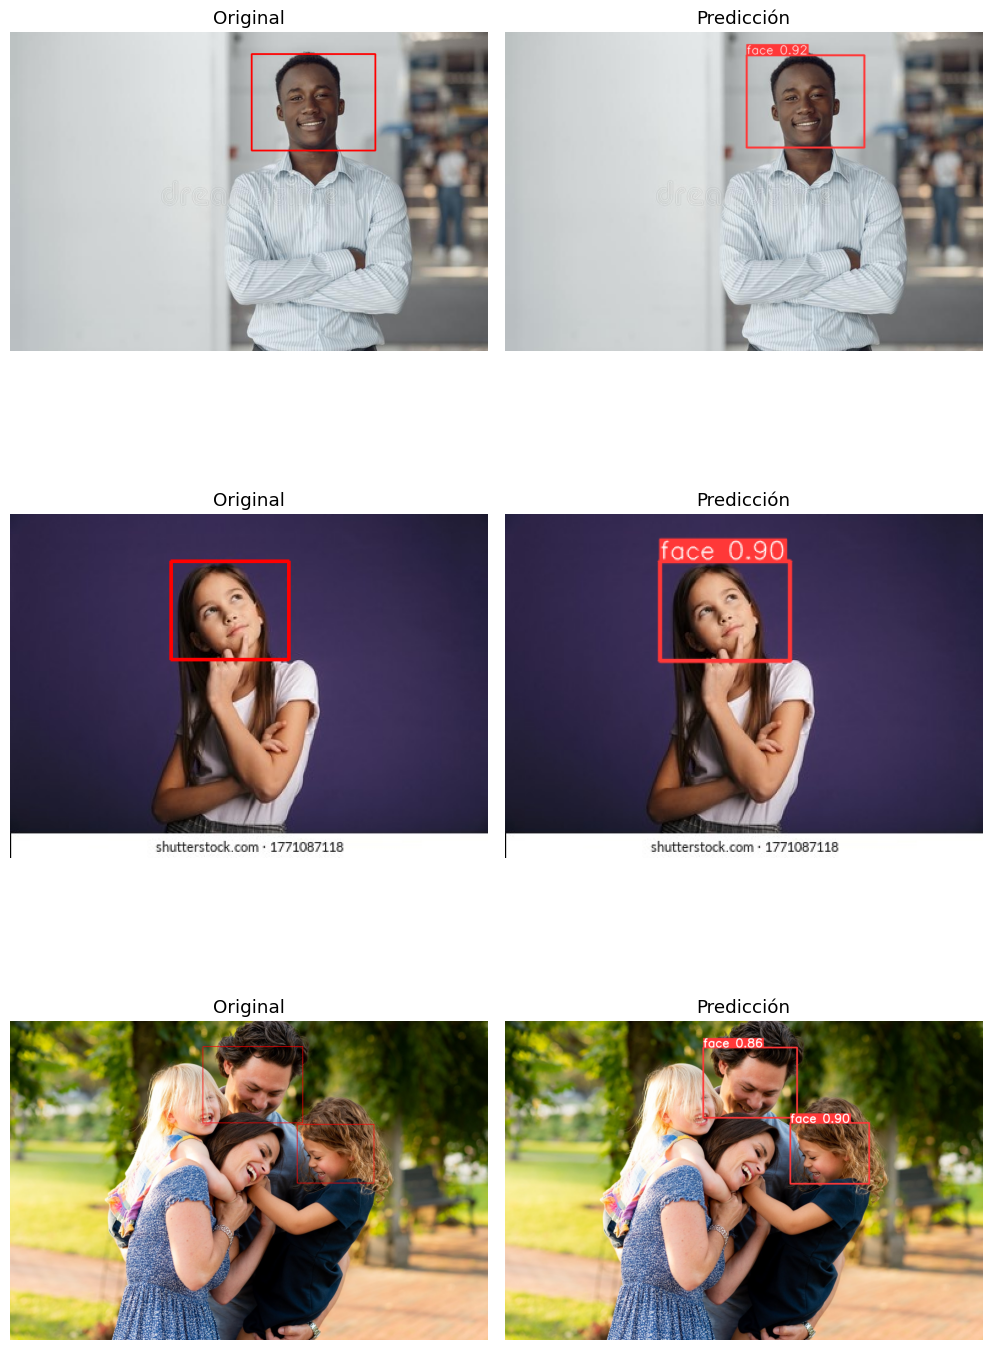

In [ ]:
fig = plt.figure(figsize=(15,15))
arr = [1,2,4,5,7,8]

for i in range(0,6,2):
  test_image = test_files[i].split(".")[0]+".jpg"
  image_path = "/content/yolov5/dataset/images/test/"+test_image
  ax = plt.subplot(3, 3, arr[i])
  img = cv2.imread(image_path, 1)
  img = graph_annotation(img, i)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Original")
  plt.axis("off")

  results = model_v5(image_path)
  results.render()

  ax = plt.subplot(3, 3, arr[i+1])
  plt.imshow(results.ims[0])
  plt.title("Predicción")
  plt.axis("off")
  plt.tight_layout()

## Búsqueda de Hiperparámetros

A fin de identificar el modelo más apropiado para efectuar la detección de rostros en datos no vistos, se ejecuta la búsqueda de los valores óptimos de los hiperparámetros de la red. El comando a continuación ejecuta un script de entrenamiento para el modelo YOLOv5, especificando el tamaño de imagen (640x640 píxeles), tamaño de lote (16), número de épocas (20) y la ruta del archivo de configuración de datos (`faces.yaml`). Utiliza pesos preentrenados de `yolov5l.pt` para transferencia de aprendizaje, mejorando la eficiencia y efectividad del entrenamiento. El flag `--evolve 10` indica que se realizará una búsqueda de hiperparámetros empleando el algoritmo de optimización evolutiva, probando 10 variaciones para encontrar la configuración óptima que mejore el rendimiento del modelo (es decir, por 10 generaciones).

Los principales hiperparámetros en YOLOv5 son:

* lr0: Tasa de aprendizaje inicial.
* lrf: Factor de reducción de tasa de aprendizaje.
* momentum: Factor de momentum para el optimizador.
* weight_decay: Factor de penalización de peso.
* warmup_epochs: Número de épocas de calentamiento.
* warmup_momentum: Momentum durante el calentamiento.
* warmup_bias_lr: Tasa de aprendizaje de sesgo durante el calentamiento.
* box_loss: Peso de la pérdida de coordenadas de caja.
* cls_loss: Peso de la pérdida de clasificación.
* cls_pw: Peso de clase para el equilibrio de clasificación.
* obj_loss: Peso de la pérdida de detección de objeto.
* obj_pw: Peso de objeto para el equilibrio de detección de objeto.
* iou_t: Umbral de IoU para verdadero positivo.
* anchor_t: Umbral de ajuste de anclaje.
* fl_gamma: Parámetro gamma para focal loss.
* hsv_h, hsv_s, hsv_v: Augmentación de cambio de color HSV.
* degrees, translate, scale, shear, perspective: Augmentación geométrica.
* flipud, fliplr, mosaic, mixup, copy_paste: Augmentación de datos de entrada.
* anchors: Número de anclajes a utilizar.

Por último, respecto al valor que se busca maximizar en el proceso, en YOLOv5 se define una función de aptitud predeterminada como una combinación ponderada de métricas: mAP50 contribuye con el 10% del peso y mAP50-95 contribuye con el 90% restante: [Documentación de Ultralytics YOLOv5](https://docs.ultralytics.com/yolov5/tutorials/hyperparameter_evolution/). Cabe destacar que la inicialización de los hiperparámetros y la evolución de estos, la cual se fundamenta en los operadores de cruce y mutación, se efectúan de acuerdo con la configuración predeterminada del script.

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 20 --data /content/yolov5/faces.yaml --weights yolov5l.pt --evolve 10

train: weights=yolov5l.pt, cfg=, data=/content/yolov5/faces.yaml, hyp=../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=10, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_g

Los valores de hiperparámetros encontrados (por ejemplo, `lr0=0.01089`, `momentum=0.97462`, etc.) indican las magnitudes que el proceso de búsqueda de hiperparámetros ha determinado como las que obtienen las mejores métricas en el entrenamiento de YOLOv5 para la tarea planteada. La justificación detrás de estos valores se basa en la optimización para maximizar el rendimiento de YOLOv5 en términos de la precisión en la detección de objetos (mAP).  Los resultados se almacenan en un archivo `.yaml` llamado `hyp_evolve.yaml`. Siendo así, ahora se entrena un nuevo modelo utilizando esta configuración.

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 20 --data /content/yolov5/faces.yaml --weights yolov5l.pt --hyp /content/yolov5/runs/evolve/exp/hyp_evolve.yaml

train: weights=yolov5l.pt, cfg=, data=/content/yolov5/faces.yaml, hyp=/content/yolov5/runs/evolve/exp/hyp_evolve.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01089, lrf=0.01, momentum=0.97462, weight_decay=0.00048, warmup_epochs=3.0898, warmup_momentum=0.95, warmup_bias_lr=0.10288, box=0.05877, cls=0.5483, cls_pw=1.0522, obj=1.0948, obj_pw

Ahora se evaluará el desempeño de este modelo.

In [ ]:
!python /content/yolov5/val.py --weights /content/best_tunned_yolov5.pt --data /content/yolov5/faces.yaml --task test

val: data=/content/yolov5/faces.yaml, weights=['/content/best_yolov5_large.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=../yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
test: Scanning /content/yolov5/dataset/labels/test.cache... 441 images, 0 backgrounds, 0 corrupt: 100% 441/441 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 14/14 [00:08<00:00,  1.61it/s]
                   all        441        676      0.952      0.963      0.984       0.77
Speed: 0.2ms pre-process, 7.7ms inference, 1.2ms NMS per image at shape (32, 3, 640, 64

De nuevo, se desea evaluar visualmente la precisión y eficacia del modelo al detectar objetos, exponiendo directamente las diferencias entre las ubicaciones anotadas manualmente y las áreas identificadas por la red.

In [ ]:
model_path = "/content/best_tunned_yolov5.pt"
model_tunned_v5 = torch.hub.load("ultralytics/yolov5:master", "custom", path=model_path)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-10-20 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
Adding AutoShape... 


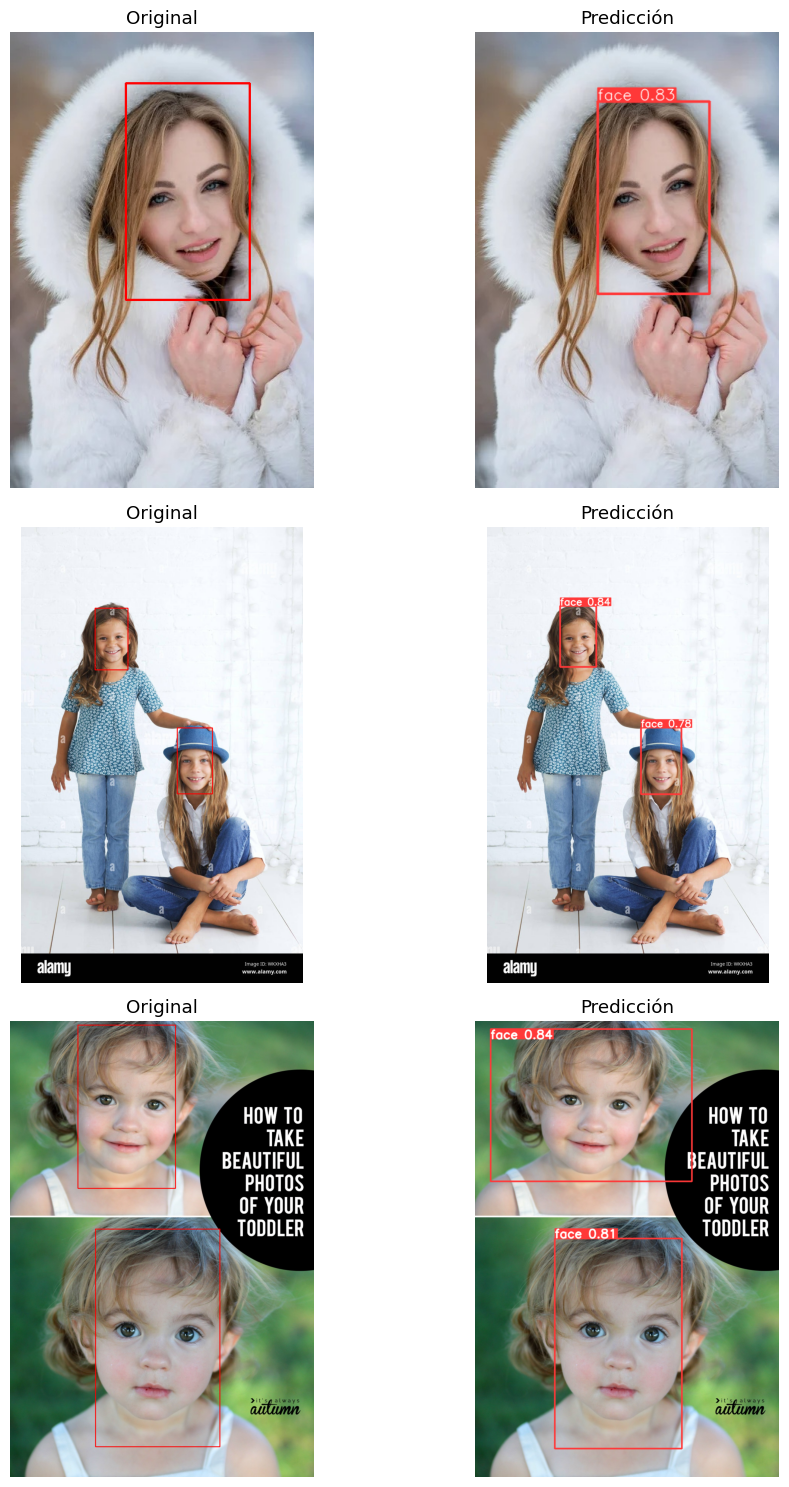

In [ ]:
fig = plt.figure(figsize=(15,15))
arr = [1,2,4,5,7,8]

for i in range(0,6,2):
  test_image = test_files[i].split(".")[0]+".jpg"
  image_path = "/content/yolov5/dataset/images/test/"+test_image
  ax = plt.subplot(3, 3, arr[i])
  img = cv2.imread(image_path, 1)
  img = graph_annotation(img, i)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Original")
  plt.axis("off")

  results = model_tunned_v5(image_path)
  results.render()

  ax = plt.subplot(3, 3, arr[i+1])
  plt.imshow(results.ims[0])
  plt.title("Predicción")
  plt.axis("off")
  plt.tight_layout()

# YOLOv8

## Entrenamiento

YOLOv8, introducido en 2022, es más rápido y preciso que YOLOv5 y ofrece un marco unificado para varias tareas de visión por computadora. Pese a que YOLOv5 es más fácil de implementar, en aplicaciones que requieren detección de objetos en tiempo real, YOLOv8 es la mejor opción [YOLOv8 vs. YOLOv5: Choosing the Best Object Detection Model](https://www.augmentedstartups.com/blog/yolov8-vs-yolov5-choosing-the-best-object-detection-model). A fin de corrborar su potencial, se procede con la instalación de las librerías requeridas para la utilización de YOLOv8.

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 8.3 MB/s eta 0:00:00


Se carga el modelo YOLO preentrenado desde el archivo `yolov8l.pt`. Posteriormente, se lleva a cabo el entrenamiento en el conjunto de datos especificado en el YAML `faces.yaml` durante 20 épocas. Los resultados del entrenamiento (como los pesos del modelo, las gráficas de pérdida, etc.) se almacenarán en el directorio `/content/yolov8`.


In [ ]:
model = YOLO("yolov8l.pt")
model.train(data="/content/yolov5/faces.yaml", epochs=20, project = "/content/yolov8")

## Evaluación

Se efectúa la validación del modelo con los pesos que se han determinado como los mejores durante el entrenamiento (almacenados en `best.pt` o en `best_yolov8_large.pt` dependiendo si el archivo se ha cargado manualmente o si se ha entrenado en esta ejecución).

In [ ]:
#best_model_v8 = YOLO("/content/yolov8/train/weights/best.pt")
best_model_v8 = YOLO("/content/best_yolov8_large.pt")

In [ ]:
metrics = best_model_v8.val()
metrics

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /content/yolov5/dataset/labels/valid.cache... 353 images, 0 backgrounds, 0 corrupt: 100%|██████████| 353/353 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.50it/s]
                   all        353        511      0.824      0.953      0.937      0.682
Speed: 0.4ms preprocess, 8.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ab3863996f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Nuevamente, el objetivo es visualizar y comparar las anotaciones originales contra las predicciones del modelo YOLOv8 empleando las imágenes de pruebas.


image 1/1 /content/yolov5/dataset/images/test/00001179.jpg: 448x640 1 face, 119.2ms
Speed: 2.7ms preprocess, 119.2ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/yolov5/dataset/images/test/00002971.jpg: 480x640 1 face, 77.2ms
Speed: 2.5ms preprocess, 77.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/yolov5/dataset/images/test/00002127.jpg: 448x640 3 faces, 50.8ms
Speed: 2.6ms preprocess, 50.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


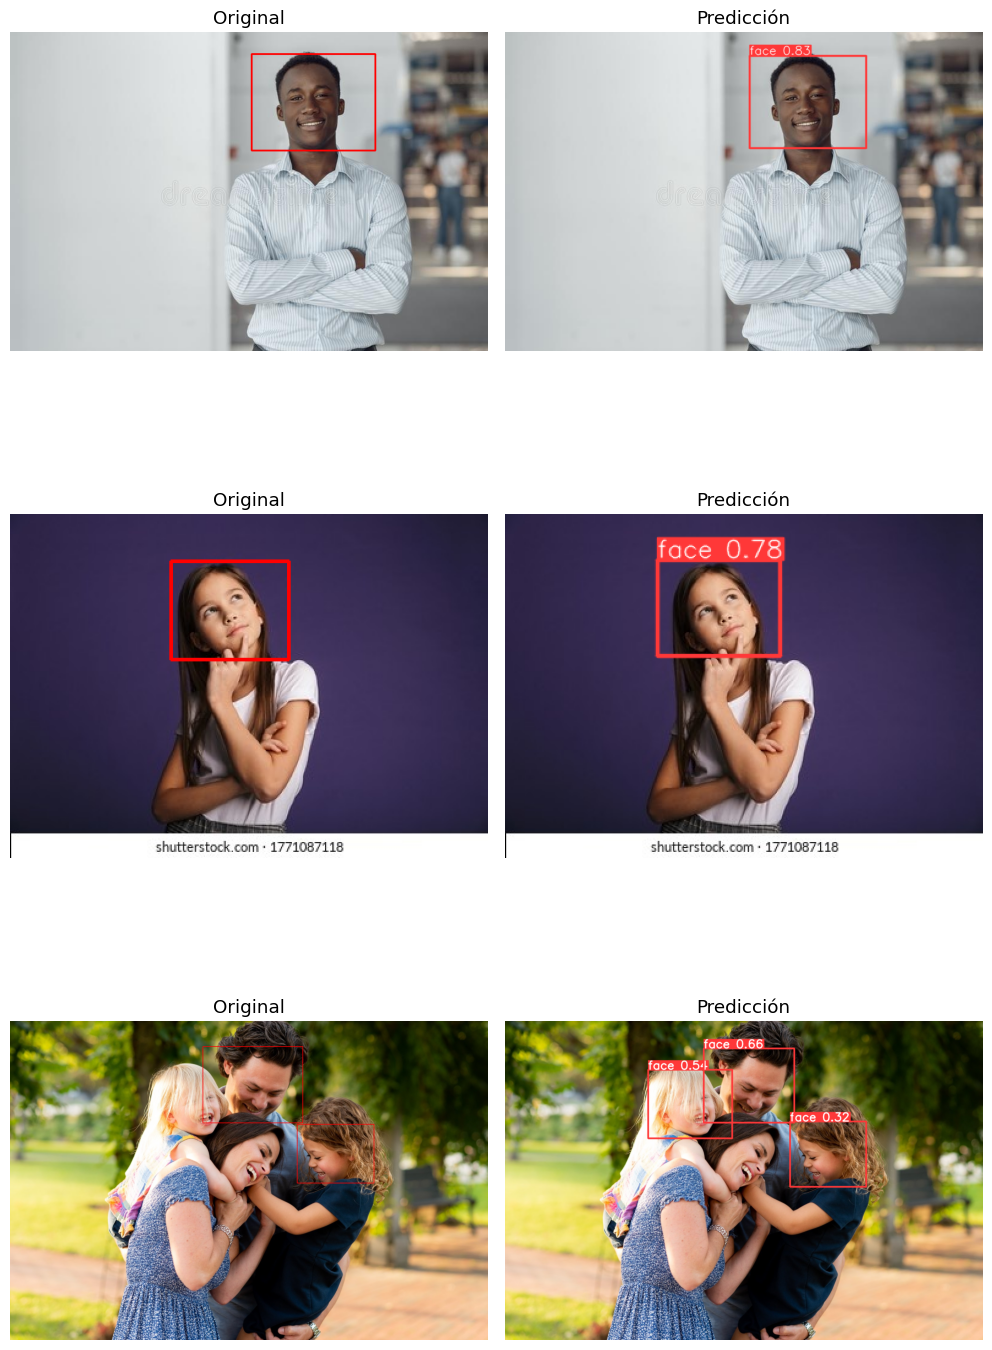

In [ ]:
fig = plt.figure(figsize=(15,15))
arr = [1,2,4,5,7,8]
for i in range(0,6,2):
  test_image = test_files[i].split(".")[0]+".jpg"
  image_path = "/content/yolov5/dataset/images/test/"+test_image

  ax = plt.subplot(3, 3, arr[i])
  img = cv2.imread(image_path, 1)
  img = graph_annotation(img, i)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Original")
  plt.axis("off")

  results = best_model_v8.predict(image_path)

  ax = plt.subplot(3, 3, arr[i+1])
  plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
  plt.title("Predicción")
  plt.axis("off")
  plt.tight_layout()

## Búsqueda de Hiperparámetros

A fin de identificar el modelo más apropiado para efectuar la detección de rostros en datos no vistos, se ejecuta la búsqueda de los valores óptimos de los hiperparámetros de la red. El comando a continuación ejecuta un script de entrenamiento para el modelo YOLOv8, especificando el número de épocas (20), la ruta del archivo de configuración de datos (`faces.yaml`) y el optimizador (Adam). Utiliza pesos preentrenados de `yolov5l.pt` para transferencia de aprendizaje, mejorando la eficiencia y efectividad del entrenamiento.


In [ ]:
model_hp = YOLO("yolov8l.pt")
model_hp.tune(data="/content/yolov5/faces.yaml", epochs=20, project = "/content/yolov8", optimizer='AdamW', plots=False, save=False, val=False)

In [ ]:
model_tunned_v8 = YOLO("/content/best_tunned_yolov8.pt")

Ahora se evaluará el desempeño de este modelo.

In [ ]:
metrics = model_tunned_v8.val()
metrics

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/yolov5/dataset/labels/valid.cache... 353 images, 0 backgrounds, 0 corrupt: 100%|██████████| 353/353 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.45it/s]
                   all        353        511      0.853      0.921      0.938      0.668
Speed: 0.9ms preprocess, 1.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ab3860b28c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

De nuevo, se desea evaluar visualmente la precisión y eficacia del modelo al detectar objetos, exponiendo directamente las diferencias entre las ubicaciones anotadas manualmente y las áreas identificadas por la red.


image 1/1 /content/yolov5/dataset/images/test/00002244.jpg: 640x448 1 face, 39.0ms
Speed: 5.2ms preprocess, 39.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/yolov5/dataset/images/test/00002871.jpg: 640x416 2 faces, 207.1ms
Speed: 3.3ms preprocess, 207.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /content/yolov5/dataset/images/test/00003085.jpg: 640x448 2 faces, 40.5ms
Speed: 3.8ms preprocess, 40.5ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 448)


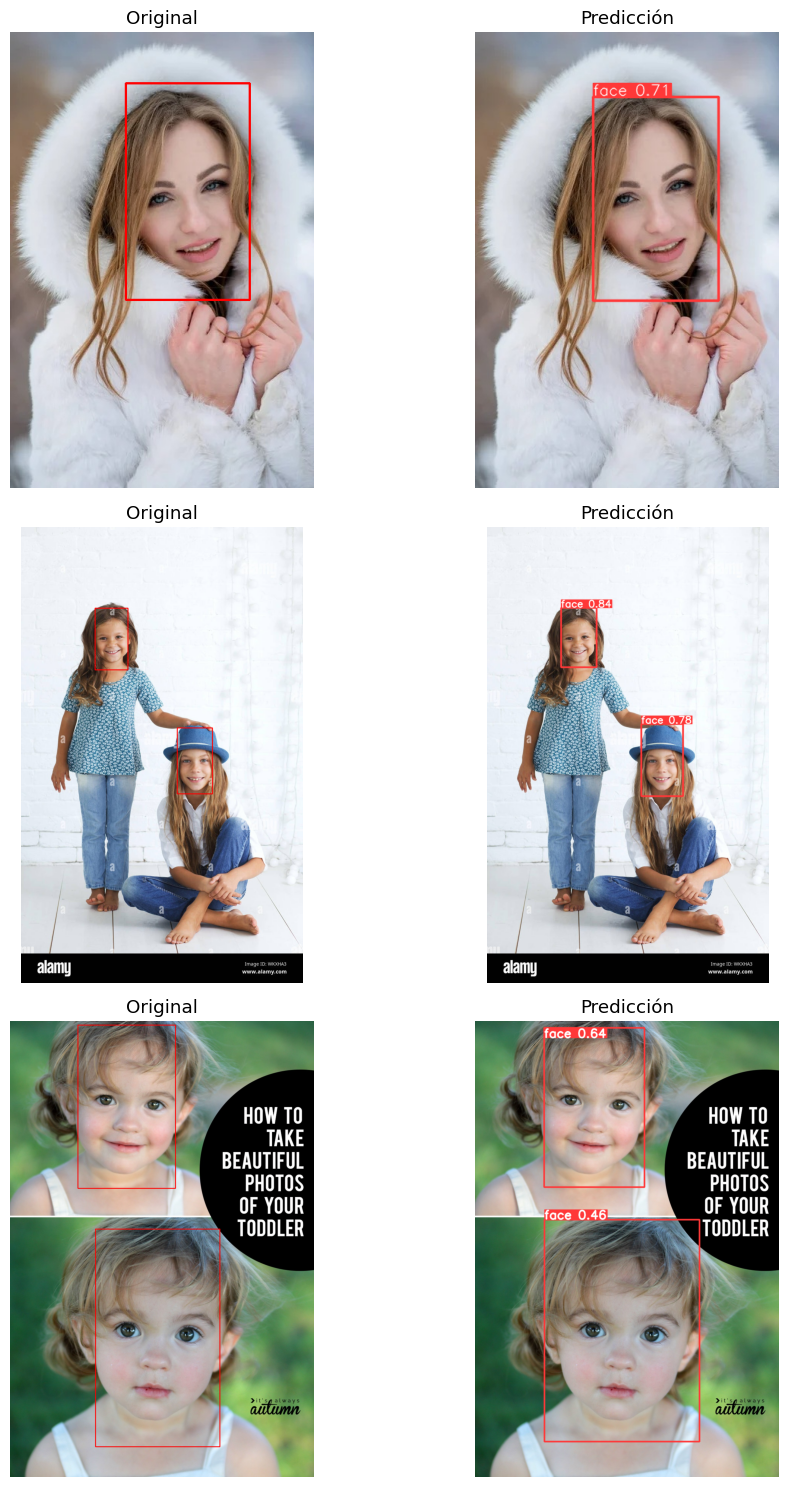

In [ ]:
fig = plt.figure(figsize=(15,15))
arr = [1,2,4,5,7,8]
for i in range(0,6,2):
  test_image = test_files[i].split(".")[0]+".jpg"
  image_path = "/content/yolov5/dataset/images/test/"+test_image

  ax = plt.subplot(3, 3, arr[i])
  img = cv2.imread(image_path, 1)
  img = graph_annotation(img, i)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Original")
  plt.axis("off")

  results = model_tunned_v8.predict(image_path)

  ax = plt.subplot(3, 3, arr[i+1])
  plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
  plt.title("Predicción")
  plt.axis("off")
  plt.tight_layout()

# Conclusión

Las estadísticas proporcionadas en las etapas de evaluación son indicadores clave del rendimiento en modelos de clasificación y localización de objetos, en este caso, YOLO. En primera instancia, YOLOv5 revela un rendimiento robusto, evidenciado por métricas obtenidas de un conjunto de test que consta de 441 imágenes y 676 instancias de objetos. Con una precisión de 0.952, el modelo demuestra una alta proporción de verdaderos positivos frente a la suma de verdaderos y falsos positivos, siendo eficaz en la minimización de falsas detecciones. Un recall de 0.963 sugiere que se captura exitosamente el 96.3% de los rostros existentes, un indicativo de menor incidencia de falsos negativos.

El mAP (Mean Average Precision) es una métrica estándar para evaluar la calidad de los modelos de detección, mientras que mAP50 constituye una variante específica que se centra en la precisión promedio de las detecciones con un umbral de Intersección sobre Unión (IoU) del 50%. IoU es una medida de la superposición entre dos áreas, generalmente entre el rectángulo delimitador predicho por el modelo y el real en los datos de entrada. Un IoU del 50% señala que el solapamiento entre las cajas delimitadoras predichas y las verdaderas debe ser al menos del 50% para que la detección se considere correcta. Por su lado, el mAP es el promedio de la precisión de detección calculada para cada clase de objeto en la colección de imágenes. El mAP50 es útil porque proporciona una evaluación estandarizada del rendimiento del modelo, asegurando que este no solo sea preciso en la identificación de rostros, sino también consistente en múltiples condiciones. Al establecer un umbral de IoU del 50%, se mantiene un equilibrio entre permitir cierta flexibilidad en la precisión de la localización del elemento de interés (la caja delimitadora no tiene que ser perfecta) y asegurar que las detecciones sean efectivamente relevantes.

En este caso, el mAP50, situado en 0.984, es excepcionalmente alto puesto que implica que el modelo consigue una precisión promedio del 98.4% en detecciones con un IoU de al menos 0.5, lo que es significativo para aplicaciones prácticas. Sin embargo, el mAP50-95 de 0.77, aunque elevado, conlleva variaciones en la consistencia del modelo a través de umbrales de IoU más estrictos. Pese a que el desempeño disminuye con criterios de IoU más rigurosos, sigue siendo apropiado en la detección en escenarios con requisitos de superposición moderadamente exigentes. De tal forma, las estadísticas colectivamente resaltan la competencia de YOLOv5 en el reconocimiento facial dentro de las imágenes de prueba.

En el caso de YOLOv8, se obtienen valores ligeramente menores con el conjunto de prueba. En este escenario de evaluación, la precisión es del 0.853, el recall de 0.921, el mAP50 de 0.938 y el mAP50-95 de 0.668. Con base en las estaídsticas suministradas, YOLOv5 revela un rendimiento superior en todas las métricas clave en comparación con YOLOv8. Pese a que ambos modelos son competentes en el reconocimiento de rostros humanos, YOLOv5 parece ser más preciso y confiable en su capacidad para detectar y localizar dichos objetos de interés.